### Import Library

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import folium
import pprint
import branca.colormap as cm
import ee
import geemap
from folium.plugins import Draw
import geopandas as gpd

In [2]:
import matplotlib.font_manager as fm

font_path = 'C:/WINDOWS/Fonts/H2HDRM.TTF'
# 폰트 프로퍼티 설정
font_prop = fm.FontProperties(fname=font_path, size=14)

# matplotlib의 폰트를 설정
plt.rcParams['font.family'] = font_prop.get_name()

### Google Earth API 인증

In [3]:
import os

os.environ['EARTHENGINE_API_KEY'] = 'Your API key'

In [4]:
# # Earth Engine 인증
# ee.Authenticate()

# Earth Engine 초기화
ee.Initialize()

### 관심 기간 및 관심 지역 설정

In [5]:
# 관심 기간의 시작일
i_date = "2023-01-01"

# 관심 기간의 종료일
f_date = "2023-12-31"

In [6]:
# 국립공원으로 제한 
park = ee.FeatureCollection("WCMC/WDPA/current/polygons") \
    .filter(ee.Filter.eq("NAME", "Bukhansan"))

park_geo = park.geometry()

location = park_geo.centroid().coordinates().getInfo()[::-1]

In [7]:
# Folium 지도에 레이어 추가 함수
def add_ee_layer(self, ee_image_object, vis_params, name):
    """Adds a method for displaying Earth Engine image tiles to folium map."""
    map_id_dict = ee.Image(ee_image_object).getMapId(vis_params)
    folium.raster_layers.TileLayer(
        tiles=map_id_dict["tile_fetcher"].url_format,
        attr="Map Data &copy; <a href='https://earthengine.google.com/'>Google Earth Engine</a>",
        name=name,
        overlay=True,
        control=True,
    ).add_to(self)


# Add Earth Engine drawing method to folium.
folium.Map.add_ee_layer = add_ee_layer

### 깊이에 따른 토양 성분 데이터 수집
- 토양을 구성하는 다양한 깊이에서의 모래, 흙, 유기탄소의 함량 데이터를 OpenLandMap 제공되는 데이터셋에서 가져온다 (250m 해상도)

In [8]:
# 토양 성분 수집
def get_soil_prop(param):
    """
        "sand"     - 모래 함량
        "clay"     - 점토 함량
        "orgc"     - 유기 탄소 함량
    """
    if param == "sand":  # 모래 함량 [%w]
        snippet = "OpenLandMap/SOL/SOL_SAND-WFRACTION_USDA-3A1A1A_M/v02"
        # 데이터셋 설명에 따른 스케일 팩터 정의.
        scale_factor = 1 * 0.01

    elif param == "clay":  # 점토 함량 [%w]
        snippet = "OpenLandMap/SOL/SOL_CLAY-WFRACTION_USDA-3A1A1A_M/v02"
        # 데이터셋 설명에 따른 스케일 팩터 정의.
        scale_factor = 1 * 0.01

    elif param == "orgc":  # 유기 탄소 함량 [g/kg]
        snippet = "OpenLandMap/SOL/SOL_ORGANIC-CARBON_USDA-6A1C_M/v02"
        # 데이터셋 설명에 따른 스케일 팩터 정의.
        scale_factor = 5 * 0.001  # kg/kg로 변환하기 위함.
    else:
        return print("error")

    # ee.Image에 적용합니다.
    dataset = ee.Image(snippet).multiply(scale_factor)

    return dataset

In [9]:
# 데이터가 있는 토양 깊이 [cm].
olm_depths = [0, 10, 30, 60, 100, 200]

# 참조 깊이와 연결된 밴드 이름.
olm_bands = ["b" + str(sd) for sd in olm_depths]

In [10]:
# 모래 함량과 관련된 이미지.
sand = get_soil_prop("sand")

# 점토 함량과 관련된 이미지.
clay = get_soil_prop("clay")

# 유기 탄소 함량과 관련된 이미지.
orgc = get_soil_prop("orgc")

# 유기 탄소 함량을 유기물 함량으로 변환.
orgm = orgc.multiply(1.724)

In [11]:
# 시들음점과 토양의 최대 수분용량을 위한 두 개의 상수 이미지 초기화.
wilting_point = ee.Image(0)
field_capacity = ee.Image(0)

# 각 표준 깊이에 대한 계산을 루프를 사용하여 수행.
for key in olm_bands:
    # 적절한 깊이에서 모래, 점토, 유기물 얻기.
    si = sand.select(key)
    ci = clay.select(key)
    oi = orgm.select(key)

    # 시들음점 계산.
    # 주어진 깊이에 필요한 theta_1500t 매개변수.
    theta_1500ti = (
        ee.Image(0)
        .expression(
            "-0.024 * S + 0.487 * C + 0.006 * OM + 0.005 * (S * OM)\
            - 0.013 * (C * OM) + 0.068 * (S * C) + 0.031",
            {
                "S": si,
                "C": ci,
                "OM": oi,
            },
        )
        .rename("T1500ti")
    )

    # 시들음점을 위한 최종 식.
    wpi = theta_1500ti.expression(
        "T1500ti + (0.14 * T1500ti - 0.002)", {"T1500ti": theta_1500ti}
    ).rename("wpi")

    # 전체 시들음점을 ee.Image에 새 밴드로 추가.
    wilting_point = wilting_point.addBands(wpi.rename(key).float())

    # 최대 수분용량 계산을 위한 동일한 과정.
    # 주어진 깊이에 필요한 theta_33t 매개변수.
    theta_33ti = (
        ee.Image(0)
        .expression(
            "-0.251 * S + 0.195 * C + 0.011 * OM +\
            0.006 * (S * OM) - 0.027 * (C * OM)+\
            0.452 * (S * C) + 0.299",
            {
                "S": si,
                "C": ci,
                "OM": oi,
            },
        )
        .rename("T33ti")
    )

    # 토양의 최대 수분용량을 위한 최종 식.
    fci = theta_33ti.expression(
        "T33ti + (1.283 * T33ti * T33ti - 0.374 * T33ti - 0.015)",
        {"T33ti": theta_33ti.select("T33ti")},
    )

    # 전체 최대 수분용량을 ee.Image에 새 밴드로 추가.
    field_capacity = field_capacity.addBands(fci.rename(key).float())

모래, 점토, 유기탄소 함량을 안다면 수식을 통해 해당 토양의 시들음 시점과 최대 수분용량을 알 수 있다.
- 시들음 시점
    - 식물이 토양에서 물을 흡수하기 어려워지는 수분 함량 시점으로 뿌리가 물을 빨아들일 수 있는지 없는지의 기준점을 말한다. 
    - 예를 들어 시들음점이 10%라면, 해당 토양 수분이 10% 밑으로 떨어질 시 식물은 더이상 물을 공급 받지 못하고 시들게된다.
    - 따라서 시들음점이 높은 토양에서 자라는 식물은 뿌리가 흡수할 수 있는 물이 적기에, 물 부족에 더 민감하게 반응하며 자주 관개가 필요하다
    - 예를 들어 시들음점이 80%라면, 해당 토양 수분이 80% 밑으로 떨어질 시 시들기 시작하므로 토양 관리를 위해 인공적으로 물을 공급해줄 필요가 있다.
    - 따라서, 시들음점을 알면 식물들이 건강하게 자라기 위한 토양 조건을 알 수 있고, 물의 추가 공급 유무를 알 수 있다.
- 토양 최대 수분용량
    - 토양이 물을 최대로 저장할 수 있는 시점으로, 그 시점 이후에는 중력에 의해 물이 지하로 침투하기 시작한다.

In [12]:
# 강수량 데이터 가져오기.
pr = (
    ee.ImageCollection("UCSB-CHG/CHIRPS/DAILY")
    .select("precipitation")
    .filterDate(i_date, f_date)
    .filterBounds(park)  # 한국 지역에 대한 필터링.
)

# 잠재 증발산량(PET)과 그 품질 지표(ET_QC) 가져오기.
pet = (
    ee.ImageCollection("MODIS/061/MOD16A2")
    .select(["PET", "ET_QC"])
    .filterDate(i_date, f_date)
    .filterBounds(park)  # 한국 지역에 대한 필터링.
)

# `수정사항`
- `잠재 증발산량을 가져오는 데이터셋을 MODIS/061/MOD16A2 로 변경`

- 강수량 데이터는 Climate Hazards Group InfraRed Precipitation with Station data(CHIRPS)에서 제공되는 데이터셋 (매일 갱신, 해상도 5km)
- 증발산량 데이터는 MODIS Terra Net에서 제공되는 데이터셋 (8일에 한번, 해상도 500m)
    - 증발산량은 증발과 증산을 합친 것으로 증산은 식물이 수분을 흡수하여 잎을 통해 대기중으로 방출하는 것을 말한다.
    - 이 데이터셋에서 제공되는 증발산량은 적설량, 지역의 경사도에서 유출이 심한 점 등을 배제한 데이터로 잠재 증발산량으로 명명한다.

#### 시간 규모에 따른 데이터 재샘플링

In [13]:
# 시간 규모 재샘플링
def sum_resampler(coll, freq, unit, scale_factor, band_name):
    """
    coll: (ee.ImageCollection) 한 밴드만 처리 가능
    freq: (int) 재샘플링 빈도에 해당
    unit: (str) 재샘플링 시간 단위. 'day', 'month', 'year'이어야 함
    scale_factor (float): 적절한 단위로 값을 얻기 위한 스케일링 인자
    band_name (str) 출력 밴드의 이름
    """

    # 컬렉션의 초기 및 최종 날짜 정의.
    firstdate = ee.Date(
        coll.sort("system:time_start", True).first().get("system:time_start")
    )
    lastdate = ee.Date(
        coll.sort("system:time_start", False).first().get("system:time_start")
    )

    # 두 날짜 사이의 시간 차이 계산.
    diff_dates = lastdate.difference(firstdate, unit)

    # 새로운 시간 인덱스(출력용) 정의.
    new_index = ee.List.sequence(0, ee.Number(diff_dates), freq)

    # 새 시간 인덱스에 적용할 함수 정의.
    def apply_resampling(date_index):
        # 고려할 시작 날짜 정의.
        startdate = firstdate.advance(ee.Number(date_index), unit)
        # 원하는 빈도에 따라 고려할 종료 날짜 정의.
        enddate = startdate.advance(freq, unit)
        # 시작 및 종료 날짜 사이의 일수 계산.
        diff_days = enddate.difference(startdate, "day")
        # 합성 이미지 계산.
        image = (
            coll.filterDate(startdate, enddate)
            .mean()
            .multiply(diff_days)
            .multiply(scale_factor)
            .rename(band_name)
        )
        # 적절한 시간 인덱스를 가진 최종 이미지 반환.
        return image.set("system:time_start", startdate.millis())

    # 새 시간 인덱스에 함수 매핑.
    res = new_index.map(apply_resampling)

    # 결과를 ee.ImageCollection으로 변환.
    res = ee.ImageCollection(res)

    return res

In [14]:
# 강수량 데이터셋에 재샘플링 함수 적용.
pr_m = sum_resampler(pr, 1, "month", 1, "pr")

In [15]:
# 증발산량 데이터셋에 재샘플링 함수 적용.
pet_m = sum_resampler(pet.select("PET"), 1, "month", 0.0125, "pet")

▲ 데이터셋을 월별 강수량/증발산량으로 재샘플링
- 해상도 및 데이터를 습득한 시간이 다르므로 재샘플링하여 단위를 맞춰준다.

In [16]:
# 강수량과 증발산량 데이터셋 병합.
meteo = pr_m.combine(pet_m)

#### 토양 깊이에 따른 토양 함량의 평균 값 계산

In [17]:
# 깊이에 따른 토양 속성의 평균 값을 계산하는 함수.
def olm_prop_mean(olm_image, band_output_name):
    """
    식물이 뿌리를 통해 접근할 수 있는 토양 깊이에 걸쳐 있는 수분 함량
    """
    mean_image = olm_image.expression(
        "(b0 + b10 + b30 + b60 + b100 + b200) / 6",
        {
            "b0": olm_image.select("b0"),
            "b10": olm_image.select("b10"),
            "b30": olm_image.select("b30"),
            "b60": olm_image.select("b60"),
            "b100": olm_image.select("b100"),
            "b200": olm_image.select("b200"),
        },
    ).rename(band_output_name)

    return mean_image

In [18]:
zr = ee.Image(0.5)
p = ee.Image(0.5)

zr은 식물의 뿌리 깊이에 대한 비율을

p는 필드 용량에 대한 토양의 현재 수분 함량 비율을 나타낸다

In [19]:
# 필드 용량과 시듦점에 함수 적용.
fcm = olm_prop_mean(field_capacity, "fc_mean")
wpm = olm_prop_mean(wilting_point, "wp_mean")

# 이론적으로 사용 가능한 물 계산
# 토양 최대 수분용량 - 시들음점 차이 계산
taw = (
    (fcm.select("fc_mean").subtract(wpm.select("wp_mean"))).multiply(1000).multiply(zr)
)

# 토양 최대 수분용량에 저장된 물 계산.
stfc = taw.multiply(p)

시들음점과 토양 최대 수분용량을 통해 다음과 같은 식을 도출할 수 있다.
- TAW = 1000 * (토양 최대 수분용량 - 시들음점) * 뿌리깊이
- `TAW`는 식물이 건강하게 성장할 수 있음과 동시에 사용가능한 물의 양을 나타낸다.
- TAW에 0과 1사이의 임의의 p값을 곱한 값이 `STFC`로 토양이 해당뿌리깊이에 해당하는 실제 수분량을 뜻한다.

#### 초기 상태 설정
    - 지하수 유입량을 시간에 따라 추정하기 위해

In [20]:
# 컬렉션의 시작에 따라 초기 시간(time0)을 정의합니다.
time0 = meteo.first().get("system:time_start")

In [21]:
# 토양의 수분 상태를 설명하는 모든 밴드를 초기화합니다.
# 데이터 유형을 .float()로 형변환하는 것을 잊지 마세요.

# 초기 유입량 설정.
initial_rech = ee.Image(0).set("system:time_start", time0).select([0], ["rech"]).float()

# 누적 잠재적 수분 손실(APWL) 초기화.
initial_apwl = ee.Image(0).set("system:time_start", time0).select([0], ["apwl"]).float()

# 저장된 수분 초기화.
initial_st = stfc.set("system:time_start", time0).select([0], ["st"]).float()

# 강수량 초기화.
initial_pr = ee.Image(0).set("system:time_start", time0).select([0], ["pr"]).float()

# 잠재 증발산량 초기화.
initial_pet = ee.Image(0).set("system:time_start", time0).select([0], ["pet"]).float()

In [22]:
# 초기 유입량 이미지에 다른 밴드들을 추가하여 모든 밴드를 하나의 이미지로 결합합니다.
initial_image = initial_rech.addBands(
    ee.Image([initial_apwl, initial_st, initial_pr, initial_pet])
)

# 생성된 이미지를 리스트에 추가합니다. 이 리스트는 시계열 분석에서 사용됩니다.
image_list = ee.List([initial_image])

#### 지하수 유입량 계산

In [23]:
def recharge_calculator(image, image_list):

    # 현재 ee.Image 컬렉션의 날짜 결정.
    localdate = image.date().millis()

    # 리스트에 저장된 이전 이미지 가져오기.
    prev_im = ee.Image(ee.List(image_list).get(-1))

    # 이전 APWL과 ST 가져오기.
    prev_apwl = prev_im.select("apwl")
    prev_st = prev_im.select("st")

    # 현재 강수량과 증발산량 가져오기.
    pr_im = image.select("pr")
    pet_im = image.select("pet")

    # 유입량, APWL, ST와 관련된 새로운 밴드 초기화
    new_rech = (
        ee.Image(0)
        .set("system:time_start", localdate)
        .select([0], ["rech"])
        .float()
    )
    new_apwl = (
        ee.Image(0)
        .set("system:time_start", localdate)
        .select([0], ["apwl"])
        .float()
    )
    new_st = (
        prev_st.set("system:time_start", localdate).select([0], ["st"]).float()
    )

    # 조건에 따라 밴드 계산 수행

    # CASE 1: PET > P 일 경우 (증발산량 > 강수량)
    zone1 = pet_im.gt(pr_im)
    # zone1에서 APWL(누적 잠재적 수분 손실) 계산
    zone1_apwl = prev_apwl.add(pet_im.subtract(pr_im)).rename("apwl")
    # zone1의 APWL 값 구현
    new_apwl = new_apwl.where(zone1, zone1_apwl)
    # zone1에서 ST(저장 수분) 계산
    zone1_st = prev_st.multiply(
        ee.Image.exp(zone1_apwl.divide(stfc).multiply(-1))
    ).rename("st")
    # zone1의 ST 값 구현
    new_st = new_st.where(zone1, zone1_st)

    # CASE 2: PET <= P 일 경우 (증발산량 <= 강수량)
    zone2 = pet_im.lte(pr_im)
    # zone2에서 ST 계산.
    zone2_st = prev_st.add(pr_im).subtract(pet_im).rename("st")
    # zone2의 ST 값 구현.
    new_st = new_st.where(zone2, zone2_st)

    # CASE 2.1: PET <= P 및 ST >= STfc 일 경우
    zone21 = zone2.And(zone2_st.gte(stfc))
    # zone21에서 유입량 계산 즉, 필드 용량 이상의 수분이 있을때, 유입량 계산
    zone21_re = zone2_st.subtract(stfc).rename("rech")
    # zone21의 유입량 값 구현.
    new_rech = new_rech.where(zone21, zone21_re)
    # zone21의 ST 값 구현.
    new_st = new_st.where(zone21, stfc)

    # CASE 2.2: PET <= P 및 ST < STfc 일 경우 즉, 필드 용량 미만의 수분이 있을때
    zone22 = zone2.And(zone2_st.lt(stfc))
    # zone22에서 APWL 계산.
    zone22_apwl = (
        stfc.multiply(-1).multiply(ee.Image.log(zone2_st.divide(stfc))).rename("apwl")
    )
    # zone22의 APWL 값 구현.
    new_apwl = new_apwl.where(zone22, zone22_apwl)

    # 유입량 계산이 가능한 영역 주위에 마스크 생성.
    mask = pet_im.gte(0).And(pr_im.gte(0)).And(fcm.gte(0)).And(wpm.gte(0))
    # 마스크 적용.
    new_rech = new_rech.updateMask(mask)

    # 모든 밴드를 새로운 ee.Image에 추가.
    new_image = new_rech.addBands(ee.Image([new_apwl, new_st, pr_im, pet_im]))

    # 새로운 ee.Image를 ee.List에 추가.
    return ee.List(image_list).add(new_image)

In [24]:
# 사용자 정의 함수를 기상 데이터 컬렉션에 적용.
rech_list = meteo.iterate(recharge_calculator, image_list)

# 리스트에서 초기 이미지 제거.
rech_list = ee.List(rech_list).remove(initial_image)

# 리스트를 ee.ImageCollection으로 변환.
rech_coll = ee.ImageCollection(rech_list)

In [25]:
# 연평균 지하수 유입량 계산
annual_rech = rech_coll.select("rech").mean().multiply(12)

# 연평균 강수량 계산
annual_pr = rech_coll.select("pr").mean().multiply(12)

In [26]:
# 관심 지역 주변에 컴포지트 ee.Images 클리핑.
rech_park = annual_rech.clip(park)
pr_park = annual_pr.clip(park)

In [27]:
# folium 지도 생성
my_map = folium.Map(location=location, zoom_start=12, zoom_control=True)

# 그리기 플러그인 추가
draw = Draw(
    export=True,
    filename='drawn_data.json',
    position='topleft',
    draw_options={
        'polyline': False,
        'rectangle': True,
        'polygon': True,
        'circle': False,
        'marker': True,
        'circlemarker': False,
    },
    edit_options={'edit': False}
)

# 그리기 플러그인을 지도에 추가
draw.add_to(my_map)

# 지하수 유입률 시각화 파라미터 설정
rech_vis_params = {
    "bands": "rech",
    "min": 0,
    "max": 500,
    "opacity": 1,
    "palette": ["red", "orange", "yellow", "green", "blue", "purple"],
}

# 강수량 시각화 파라미터 설정
pr_vis_params = {
    "bands": "pr",
    "min": 500,
    "max": 1500,
    "opacity": 1,
    "palette": ["white", "blue"],
}

# 지하수 유입률 컬러맵 정의
rech_colormap = cm.LinearColormap(
    colors=rech_vis_params["palette"],
    caption="Average annual recharge rate (mm/year)",
    vmin=rech_vis_params["min"],
    vmax=rech_vis_params["max"],
)

# 강수량 컬러맵 정의
pr_colormap = cm.LinearColormap(
    colors=pr_vis_params["palette"],
    caption= "Average annual precipitation rate (mm/year)",
    vmin=pr_vis_params["min"],
    vmax=pr_vis_params["max"],
)
# # 컬러맵을 지도에 추가
# my_map.add_child(rech_colormap)
# my_map.add_child(pr_colormap)

# 강수량 컴포지트를 지도 객체에 추가
my_map.add_ee_layer(pr_park, pr_vis_params, "Precipitation")

# 지하수 유입량을 컴포지트를 지도 객체에 추가
my_map.add_ee_layer(rech_park, rech_vis_params, "Recharge")

# 클릭 시 경도, 위도 알려줌
my_map.add_child(folium.LatLngPopup())

# 지도에 레이어 컨트롤 패널 추가
my_map.add_child(folium.LayerControl())


# 지도 표시
display(my_map)

지하수 유입량은 강수로부터 지하수 표면에 도달하는 물의 양을 의미한다.
- 빨간 계열 즉, 밝은 색은 낮은 강수량과 낮은 유입량을

  파란 계열 즉, 어두운 색은 높은 강수량 또는 높은 유입량을 의미

In [28]:
# 분석에 사용할 투영의 명목상의 해상도 [단위: 미터].
scale = 1000

In [29]:
# Step 1: GeoJSON 파일 업로드
geojson_file = 'C:/nuriho_A/drawn_data.json'  # 파일 경로 수정
region = gpd.read_file(geojson_file)

In [30]:
region_geojson = region.__geo_interface__

region_geo = ee.Geometry(region_geojson['features'][0]['geometry'])

In [31]:
region_geo

ee.Geometry({
  "functionInvocationValue": {
    "functionName": "GeometryConstructors.Polygon",
    "arguments": {
      "coordinates": {
        "constantValue": [
          [
            [
              126.980711,
              37.669648
            ],
            [
              126.980711,
              37.690593
            ],
            [
              127.025371,
              37.690593
            ],
            [
              127.025371,
              37.669648
            ],
            [
              126.980711,
              37.669648
            ]
          ]
        ]
      }
    }
  }
})

In [32]:
def ee_array_to_df(arr, list_of_bands):
    # 데이터 배열을 데이터프레임으로 변환.
    df = pd.DataFrame(arr)

    # 헤더 재배열.
    headers = df.iloc[0]
    df = pd.DataFrame(df.values[1:], columns=headers)

    # 데이터를 숫자 값으로 변환.
    for band in list_of_bands:
        df[band] = pd.to_numeric(df[band], errors="coerce")

    # 'time' 필드를 datetime으로 변환.
    df["datetime"] = pd.to_datetime(df["time"], unit="ms")

    # 관심 있는 컬럼만 유지.
    df = df[["time", "datetime", *list_of_bands]]

    # 'datetime' 컬럼을 인덱스로 설정.
    df = df.set_index("datetime")

    return df

In [33]:
# 지하수 유입량 컬렉션에서 관심 지역의 데이터를 배열로 가져옴.
arr = rech_coll.getRegion(region_geo, scale).getInfo()

# 배열을 pandas 데이터프레임으로 변환하고 인덱스를 정렬.
rdf = ee_array_to_df(arr, ["pr", "pet", "apwl", "st", "rech"]).sort_index()

In [35]:
rdf_aggregated = pd.DataFrame({
    'pr': rdf['pr'].resample('M').mean(),  # 월별 평균 강수량
    'pet': rdf['pet'].resample('M').mean(),  # 월별 평균 증발산량
    'rech': rdf['rech'].resample('M').sum()  # 월별 총 지하수 유입량
})

# `수정사항`
`기존의 증발산량, 강수량 데이터를 평균으로&지하수 유입량은 총합계로 가지고 옴`

In [36]:
rdf_aggregated

,pr,pet,rech
datetime,,,
2023-01-31,29.746859,39.047083,0.000000
2023-02-28,12.981754,60.135833,0.000000
2023-03-31,15.026515,111.373958,0.000000
2023-04-30,61.420833,129.275000,0.000000
2023-05-31,65.571652,164.119167,0.000000
2023-06-30,148.188838,195.293750,0.000000
2023-07-31,434.649838,186.490833,3351.121015
2023-08-31,245.758769,171.746458,1110.184665
2023-09-30,151.204531,115.581250,534.349211


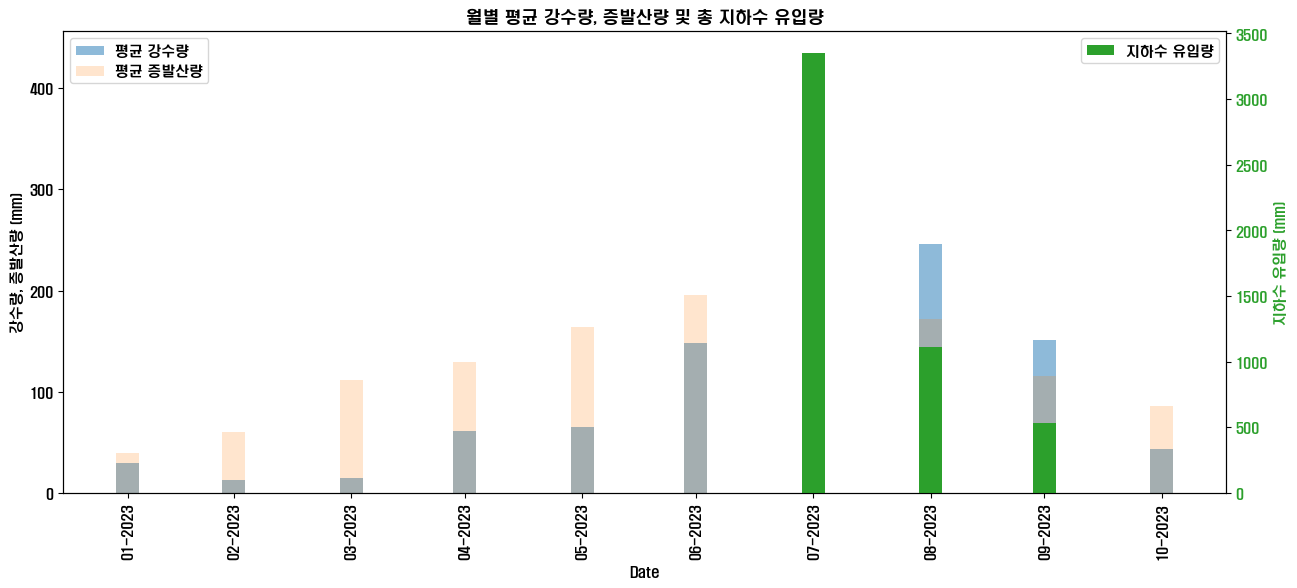

In [37]:
# 먼저, 이중 축을 사용하기 위한 준비를 합니다.
fig, ax1 = plt.subplots(figsize=(15, 6))

# 강수량 막대 그래프를 그립니다.
color_pr = 'tab:blue'
ax1.set_ylabel('강수량, 증발산량 (mm)', color='black')
ax1.bar(rdf_aggregated.index, rdf_aggregated['pr'], color=color_pr, label='평균 강수량', alpha=0.5, width=6)
# 증발산량 막대 그래프를 그립니다.
color_pet = 'tab:orange'
ax1.bar(rdf_aggregated.index, rdf_aggregated['pet'], color=color_pet, label='평균 증발산량', alpha=0.2, width=6)
ax1.set_xlabel('Date')
ax1.tick_params(axis='y', labelcolor='black')
ax1.legend(loc='upper left')

# 지하수 유입량 그래프를 그릴 두 번째 축을 만듭니다.
ax2 = ax1.twinx() 
color_rech = 'tab:green' 
ax2.set_ylabel('지하수 유입량 (mm)', color=color_rech)
ax2.bar(rdf_aggregated.index, rdf_aggregated['rech'], color=color_rech, label='지하수 유입량', alpha=1, width=6)
ax2.tick_params(axis='y', labelcolor=color_rech)
ax2.legend(loc='upper right')


# x축의 눈금을 설정합니다.
ax1.set_xticks(rdf_aggregated.index)
ax1.set_xticklabels(rdf_aggregated.index.strftime('%m-%Y'), rotation=90)

# 타이틀을 설정합니다.
plt.title('월별 평균 강수량, 증발산량 및 총 지하수 유입량')

# 그래프를 표시합니다.
plt.show()

# `수정사항`
`지하수 유입량에 비해 강수량과 증발산량 값이 너무 적어 이중축으로 나누어 사용자가 보기 쉽게 바꾸어줌`

In [38]:
# pandas 데이터프레임을 연간 기준으로 재표본하여 연간 합계를 계산합니다.
rdfy = rdf_aggregated.resample("Y").sum()

# 평균값을 계산합니다.
mean_recharge = rdfy["rech"].mean()

# 결과를 출력합니다.
print("우리 관심 지역의 연평균 지하수 유입량은", int(mean_recharge), "mm/년 입니다.")

우리 관심 지역의 연평균 지하수 유입량은 4995 mm/년 입니다.
